In [219]:
#import the basic libraries
import numpy as np
import pickle
import matplotlib.pyplot as plt


In [220]:

def seir_plot(res):
    """ Plots the epidemiological curves
    Parameters:
        res: [3D matrix, compartment_id]
    """
    plt.plot(res[::12, 0], color='r', label='S') # Take every 12 value to get steps per day (beacause of 2-hours intervals) 
    plt.plot(res[::12, 1], color='g', label='E')
    plt.plot(res[::12, 2], color='b', label='I')
    plt.plot(res[::12, 3], color='y', label='R')
    plt.plot(res[::12, 4], color='c', label='H')
    plt.legend()
    plt.show()

In [221]:
import pandas as pd
# load OD matrices
pkl_file = open('data_norway/od_counties.pkl', 'rb') # change to your desired directory
OD_matrices = pickle.load(pkl_file)
pkl_file.close()
OD_matrices = OD_matrices[:,:11,:11] 
print(OD_matrices.shape)
print(OD_matrices[0])
print(OD_matrices[2,:,:].shape)

(84, 11, 11)
[[0.8 0.  0.1 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.8 0.  0.1 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.8 0.  0.1 0.  0.  0.  0.  0.  0. ]
 [0.  0.1 0.  0.8 0.  0.1 0.  0.  0.  0.  0. ]
 [0.  0.  0.1 0.  0.8 0.  0.1 0.  0.  0.  0. ]
 [0.  0.  0.  0.1 0.  0.8 0.  0.1 0.  0.  0. ]
 [0.  0.  0.  0.  0.1 0.  0.8 0.  0.1 0.  0. ]
 [0.  0.  0.  0.  0.  0.1 0.  0.8 0.  0.1 0. ]
 [0.  0.  0.  0.  0.  0.  0.1 0.  0.8 0.  0.1]
 [0.  0.  0.  0.  0.  0.  0.  0.1 0.  0.8 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.  0.8]]
(11, 11)


In [222]:
# create population 
df_befolkningstall_fylker = pd.read_csv("data_norway/Folkemengde_fylker.csv", delimiter=";", skiprows=1)
befolkningsarray= df_befolkningstall_fylker['Befolkning per 1.1. (personer) 2020'].to_numpy(dtype='float64')
pop = np.asarray([befolkningsarray for _ in range(84)])


In [223]:
pop[13] == pop[1]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [227]:
sum(befolkningsarray)

5367580.0

In [224]:
# set up model
%run virus-sim.py

r = OD_matrices.shape[0]
n = pop.shape[1]
N = sum(befolkningsarray)

initialInd = [2] # Muncipalities that is initially infected
initial = np.zeros(n)
initial[initialInd] = 50  

model = Param(R0=2.4, DE= 5.6 * 12, DI= 5.2 * 12, I0=initial, HospitalisationRate=0.1, HospitalIters=15*12)

In [225]:
# run simulation
%run virus-sim.py

alpha = np.ones(OD_matrices.shape)
iterations = 3000
res = {}  # dictionary where the results for different cases will be found
inf = 50
res['baseline'] = seir(model, pop, OD_matrices, alpha, iterations, inf)  #baseline == no quarantine

Max number of hospitalised people:  184625 
 Day with max hospitalised people:  64


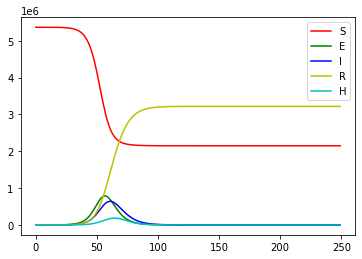

In [226]:
print("Max number of hospitalised people: ", int(res["baseline"][0][:,4].max()),
"\n",
"Day with max hospitalised people: ", int(res["baseline"][0][:,4].argmax()/12))
# plot result
seir_plot(res["baseline"][0])

## Spatial Visualisation

In [194]:
# import libraries
import pandas as pd
import geopandas as gpd
import contextily as ctx
import fiona as fi

In [195]:
# Sander cell
fylker_path = 'data_norway/Basisdata_0000_Norge_25833_Fylker_GEOJSON.geojson'
print(fi.listlayers(fylker_path))
fylker = pd.read_json('data_norway/Basisdata_0000_Norge_25833_Fylker_GEOJSON.geojson')
for fylke in fylker["administrative_enheter.fylke"].loc["features"]:

    coordinates = fylke["geometry"]["coordinates"]
    fylkesnummer = fylke['properties']['fylkesnummer']
    navn = fylke["properties"]["navn"][0]["navn"]
    polygons[(navn, fylkesnummer)] = coordinates

['administrative_enheter.avtaltavgrensningslinje', 'administrative_enheter.fylke', 'administrative_enheter.fylkesgrense', 'administrative_enheter.grunnlinje', 'administrative_enheter.lovvirkeomradegrense', 'administrative_enheter.riksgrense', 'administrative_enheter.territorialgrense']


In [196]:
from pyproj import CRS
crs = CRS.from_epsg(4326)
epsg_fylke = int(fylker["administrative_enheter.fylke"].loc["crs"]["properties"]["name"].split(":")[1]) # epsg for kartverket sin data
crs_fylke = CRS.from_epsg(epsg_fylke)

In [197]:
# 
norge_geojson = gpd.read_file("data_norway/Basisdata_0000_Norge_25833_Fylker_GEOJSON.geojson", layer = 'administrative_enheter.fylke')
norge_geojson.crs = {'init':f'epsg:{crs_fylke}'}
norge_geojson.crs = crs_fylke
norge_geojson.head()


,objtype,samiskforvaltningsomrade,lokalid,navnerom,versjonid,datafangstdato,oppdateringsdato,datauttaksdato,opphav,fylkesnummer,navn,geometry
0,Fylke,False,173158173162,https://data.geonorge.no/sosi/administrativeen...,4.1,None,20190913000000,20210104100647,None,38,"[ { ""navn"": ""Vestfold og Telemark"", ""rekkefolg...","POLYGON ((78548.430 6606728.760, 78556.900 660..."
1,Fylke,False,173153173160,https://data.geonorge.no/sosi/administrativeen...,4.1,None,20190301000000,20210104100647,None,42,"[ { ""navn"": ""Agder"", ""rekkefolge"": """", ""sprak""...","POLYGON ((12650.920 6523939.770, 12654.850 652..."
2,Fylke,False,173157173156173161,https://data.geonorge.no/sosi/administrativeen...,4.1,None,20190225000000,20210104100648,None,30,"[ { ""navn"": ""Viken"", ""rekkefolge"": """", ""sprak""...","POLYGON ((162857.290 6678845.090, 163199.630 6..."
3,Fylke,False,173152,https://data.geonorge.no/sosi/administrativeen...,4.1,None,20200207000000,20210104100648,None,11,"[ { ""navn"": ""Rogaland"", ""rekkefolge"": """", ""spr...","POLYGON ((-92079.540 6636303.790, -96094.590 6..."
4,Fylke,None,173144,https://data.geonorge.no/sosi/administrativeen...,4.1,None,20200207000000,20210104100648,None,18,"[ { ""navn"": ""Nordland"", ""rekkefolge"": """", ""spr...","POLYGON ((372929.380 7521632.830, 360585.200 7..."


In [199]:
norge_geojson.crs

<Projected CRS: EPSG:25833>
Name: ETRS89 / UTM zone 33N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 12°E and 18°E: Austria; Denmark - offshore and offshore; Germany - onshore and offshore; Norway including Svalbard - onshore and offshore.
- bounds: (12.0, 46.4, 18.01, 84.01)
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [200]:

norge_geojson_3857 = norge_geojson.to_crs(epsg=3857)  # Convert to epsg=3857 to use contextily
west, south, east, north = norge_geojson_3857.unary_union.bounds

/Users/sandernordeide/anaconda3/envs/epidemics/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [201]:
# declare baseline array storing the dynamics of the compartments 
baseline = res['baseline'][1][::12, :, :]
print(baseline.shape)
print(baseline)

(250, 5, 11)
[[[1241165.     693494.     371335.    ...  468702.     241235.
    243311.   ]
  [      0.          0.          0.    ...       0.          0.
         0.   ]
  [      0.          0.         50.    ...       0.          0.
         0.   ]
  [      0.          0.          0.    ...       0.          0.
         0.   ]
  [      0.          0.          0.    ...       0.          0.
         0.   ]]

 [[ 301994.651  516038.411  927914.789 ...  445709.39   284113.239
    362342.686]
  [      0.          0.         17.149 ...       1.314       0.
         0.352]
  [      0.          0.         19.378 ...       2.285       0.
         0.636]
  [      0.          0.          3.947 ...       0.471       0.
         0.131]
  [      0.          0.          0.    ...       0.          0.
         0.   ]]

 [[  73479.972  464118.003  856970.837 ...  513015.469  325005.496
    416577.216]
  [      0.          0.         24.127 ...       6.178       0.
         3.361]
  [      0.      

In [202]:
# declare hopsitalisation array storing the dynamics of the hospitalised 
hosp = res['baseline'][0][::12, 4]
print(hosp.shape)
print(hosp)

(250,)
[     0.         0.183      0.991      2.329      4.131      6.403
      9.204     12.626     16.793     21.862     28.025     35.517
     44.623     55.691     69.144     85.494    105.183    128.526
    156.537    190.401    231.469    281.33     341.891    415.456
    504.811    613.334    745.113    905.1     1099.282   1334.895
   1620.671   1967.128   2386.919   2895.222   3510.197   4253.492
   5150.808   6232.496   7534.17    9097.29   10969.649  13205.672
  15866.393  19018.933  22735.271  27090.048  32157.181  38005.052
  44690.212  52249.723  60692.574  69991.002  80072.871  90816.523
 102049.429 113551.546 125063.569 136299.317 146960.751 156753.691
 165402.453 172662.159 178328.266 182243.541 184303.071 184457.89
 182717.449 179150.642 173884.631 167100.575 159025.557 149920.68
 140066.119 129744.722 119226.152 108753.474  98533.576  88731.965
  79471.734  70835.9    62872.066  55598.309  49009.424  43082.871
  37784.03   33070.596  28896.072  25212.437  21972.082  

In [203]:
# find maximum hospitalisation value to make sure the color intensities in the animation are anchored against it
max_exp_ind = np.where(baseline[:, 1, :] == baseline[:, 1, :].max())[0].item()
max_exp_val = baseline[:, 1, :].max()
print(max_exp_ind, max_exp_val)

57 163705.29652932638


(256, 4)
[[1.    0.961 0.941 1.   ]
 [1.    0.958 0.937 1.   ]
 [1.    0.956 0.934 1.   ]
 ...
 [0.419 0.004 0.053 1.   ]
 [0.412 0.002 0.052 1.   ]
 [0.404 0.    0.051 1.   ]]


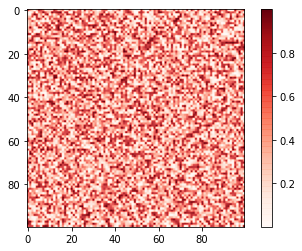

In [204]:
ncolors = 256
# get cmap
color_array = plt.get_cmap('Reds')(range(ncolors))
print(color_array.shape)
print(color_array)

# change alpha values
color_array[:, -1] = np.linspace(0.3, 1, ncolors)

# create colormap object
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap

map_object = LinearSegmentedColormap.from_list(name="Reds_transp", colors=color_array)

# register the colormap object
plt.register_cmap(cmap=map_object)

# plot some example data
fig, ax = plt.subplots()
h = ax.imshow(np.random.rand(100,100), cmap='Reds_transp')
plt.colorbar(mappable=h)

In [205]:
print(color_array)

[[1.    0.961 0.941 0.3  ]
 [1.    0.958 0.937 0.303]
 [1.    0.956 0.934 0.305]
 ...
 [0.419 0.004 0.053 0.995]
 [0.412 0.002 0.052 0.997]
 [0.404 0.    0.051 1.   ]]


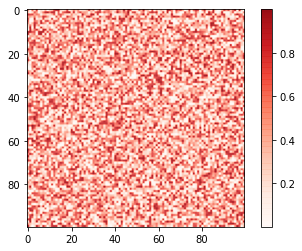

In [206]:
def trunc_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list('trunc({n}, {a:.2f}, {b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
                                                cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('Reds_transp')
new_cmap = trunc_colormap(cmap, 0.0, .9)

# plot some example data
fig, ax = plt.subplots()
h = ax.imshow(np.random.rand(100,100), cmap=new_cmap)
plt.colorbar(mappable=h)

In [207]:
print("baseline dimensions: ", baseline.shape)
print("hosp dimensions: ", hosp.shape)

baseline dimensions:  (250, 5, 11)
hosp dimensions:  (250,)


In [208]:
baseline[0, 1, :]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [213]:
params = {"axes.labelcolor":"slategrey"}
plt.rcParams.update(params)
cmap = plt.cm.get_cmap("Blues")
blue = cmap(200)

from tqdm import tqdm

for time_step in tqdm(range(1,25)):
    
    norge_geojson_3857['exposed'] = baseline[time_step-1, 1, :]
    
    #plot
    fig, ax = plt.subplots(figsize=(14,14), dpi=72)
    norge_geojson_3857.loc[norge_geojson_3857.index==84, 'exposed'] = max_exp_val + 1
    norge_geojson_3857.plot(ax=ax, facecolor='none', edgecolor='gray', alpha=0.5, linewidth=0.5, zorder=2)
    norge_geojson_3857.plot(ax=ax, column='exposed', cmap=new_cmap, zorder=3)
    # add background
    ctx.add_basemap(ax, attribution="", source=ctx.sources.ST_TONER_LITE, zoom='auto', alpha=0.6)
    
    ax.set_xlim(west, east)
    ax.set_ylim(south, north)
    ax.axis('off')
    plt.tight_layout()
    
    inset_ax = fig.add_axes([0.6, 0.14, 0.37, 0.27])
    inset_ax.patch.set_alpha(0.5)
    
    inset_ax.plot(baseline[:time_step, 0].sum(axis=1), label="susceptible", color=blue, ls='-', lw=1.5, alpha=0.8)
    inset_ax.plot(baseline[:time_step, 1].sum(axis=1), label="exposed", color='g', ls='-', lw=1.5, alpha=0.8)
    inset_ax.plot(baseline[:time_step, 2].sum(axis=1), label="infectious", color='r', ls='-', lw=1.5, alpha=0.8)
    inset_ax.plot(baseline[:time_step, 3].sum(axis=1), label="recovered", color='y', ls='-', lw=1.5, alpha=0.8)
    inset_ax.plot(hosp[:time_step], label="hospitalised", color='purple', ls='-', lw=1.5, alpha=0.8)
    
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 0].sum(), color=blue, s=50, alpha=0.2)
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 1].sum(), color='g', s=50, alpha=0.2)
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 2].sum(), color='r', s=50, alpha=0.2)
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 3].sum(), color='y', s=50, alpha=0.2)
    inset_ax.scatter((time_step-1), hosp[(time_step-1)], color='purple', s=50, alpha=0.2)
    
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 0].sum(), color=blue, s=20, alpha=0.8)
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 1].sum(), color='g', s=20, alpha=0.8)
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 2].sum(), color='r', s=20, alpha=0.8)
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 3].sum(), color='y', s=20, alpha=0.8)
    inset_ax.scatter((time_step-1), hosp[(time_step-1)], color='purple', s=20, alpha=0.8)
    
    inset_ax.fill_between(np.arange(0, time_step), np.maximum(baseline[:time_step, 0].sum(axis=1), \
                                                             baseline[:time_step, 3].sum(axis=1)), alpha=0.035, color='r')
    inset_ax.plot([time_step, time_step], [0, max(baseline[(time_step-1), 0].sum(), \
                                              baseline[(time_step-1), 3].sum())], ls='--', lw=0.7, alpha=0.8, color='r')
    
    inset_ax.set_ylabel('Population', size=18, alpha=1, rotation=90)
    inset_ax.set_xlabel('Days', size=18, alpha=1)
    inset_ax.yaxis.set_label_coords(-0.15, 0.55)
    inset_ax.tick_params(direction='in', size=10)
    inset_ax.set_xlim(-4, 254)
    inset_ax.set_ylim(-24000, 6024000)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    inset_ax.grid(alpha=0.4)
    
    inset_ax.spines['right'].set_visible(False)
    inset_ax.spines['top'].set_visible(False)
    
    inset_ax.spines['left'].set_color('darkslategrey')
    inset_ax.spines['bottom'].set_color('darkslategrey')
    inset_ax.tick_params(axis='x', colors='darkslategrey')
    inset_ax.tick_params(axis='y', colors='darkslategrey')
    plt.legend(prop={'size':14, 'weight':'light'}, framealpha=0.5)
    plt.title("Norway Covid-19 spreading on day: {}".format(time_step), fontsize=18, color= 'dimgray')
    plt.savefig("Plots_Norway/flows_{}.jpg".format(time_step), dpi=fig.dpi)
    plt.close()

  0%|          | 0/24 [00:00<?, ?it/s]<ipython-input-213-7eb10826d9d4>:18: FutureWarning: The "contextily.tile_providers" module is deprecated and will be removed in contextily v1.1. Please use "contextily.providers" instead.
  ctx.add_basemap(ax, attribution="", url=ctx.sources.ST_TONER_LITE, zoom='auto', alpha=0.6)
<ipython-input-213-7eb10826d9d4>:18: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  ctx.add_basemap(ax, attribution="", url=ctx.sources.ST_TONER_LITE, zoom='auto', alpha=0.6)
  4%|▍         | 1/24 [00:01<00:39,  1.71s/it]<ipython-input-213-7eb10826d9d4>:18: FutureWarning: The "contextily.tile_providers" module is deprecated and will be removed in contextily v1.1. Please use "contextily.providers" instead.
  ctx.add_basemap(ax, attribution="", url=ctx.sources.ST_TONER_LITE, zoom='auto', alpha=0.6)
<ipython-input-213-7eb10826d9d4>:18: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  ctx.add

In [217]:
import re

def sort_in_order( l ):
    """ sorts a given iterable
    
    l : iterable to be sorted"""
    
    convert = lambda text: int(text) if text.isdigit() else text
    alphanumeric_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanumeric_key)

from os import listdir

filenames = listdir("Plots_Norway/")
filenames = sort_in_order(filenames)
print(filenames)

['flows_1.jpg', 'flows_2.jpg', 'flows_3.jpg', 'flows_4.jpg', 'flows_5.jpg', 'flows_6.jpg', 'flows_7.jpg', 'flows_8.jpg', 'flows_9.jpg', 'flows_10.jpg', 'flows_11.jpg', 'flows_12.jpg', 'flows_13.jpg', 'flows_14.jpg', 'flows_15.jpg', 'flows_16.jpg', 'flows_17.jpg', 'flows_18.jpg', 'flows_19.jpg', 'flows_20.jpg', 'flows_21.jpg', 'flows_22.jpg', 'flows_23.jpg', 'flows_24.jpg']


In [218]:
import imageio
from tqdm import tqdm
with imageio.get_writer('Covid_19_Norway.gif', mode='I', fps=4) as writer:
    for filename in tqdm(filenames):
        image = imageio.imread('Plots_Norway/{}'.format(filename))
        writer.append_data(image)

100%|██████████| 24/24 [00:05<00:00,  4.57it/s]
